<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-признаков-на-обратимую-матрицу" data-toc-modified-id="Умножение-признаков-на-обратимую-матрицу-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Умножение признаков на обратимую матрицу</a></span><ul class="toc-item"><li><span><a href="#Теоретическое-обоснование" data-toc-modified-id="Теоретическое-обоснование-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Теоретическое обоснование</a></span></li><li><span><a href="#Практическая-проверка" data-toc-modified-id="Практическая-проверка-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Практическая проверка</a></span></li></ul></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Масштабирование признаков</a></span><ul class="toc-item"><li><span><a href="#Теоретическое-обоснование" data-toc-modified-id="Теоретическое-обоснование-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Теоретическое обоснование</a></span></li><li><span><a href="#Практическая-проверка" data-toc-modified-id="Практическая-проверка-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Практическая проверка</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Защита персональных данных клиентов

## Цель проекта

Необходимо предложить алгоритм преобразования персональных данных клиентов, который бы позволил, с одной стороны, зашифровать их, с другой стороны, не влиял бы на качество модели (линейная регрессия).

Для реализации задачи нужно:
- предложить метод преобразования;
- обосновать, что преобразование не влияет на качество модели;
- убедиться, что преобразование не позволяет интуитивно отследить персональные данные в преобразованных;
- реализовать метод и подтвердить неизменность качества модели.

In [1]:
# Импорты используемых библиотек:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

## Загрузка данных

In [2]:
# Первичный обзор данных:
try:
    df = pd.read_csv('/datasets/insurance.csv')
except:
    df = pd.read_csv('datasets/insurance.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Данные содержат 5 тыс. объектов, пропусков нет. Целевым признаком является количество страховых выплат за последние 5 лет. Рассмотрим распределения признаков и целевого признака:

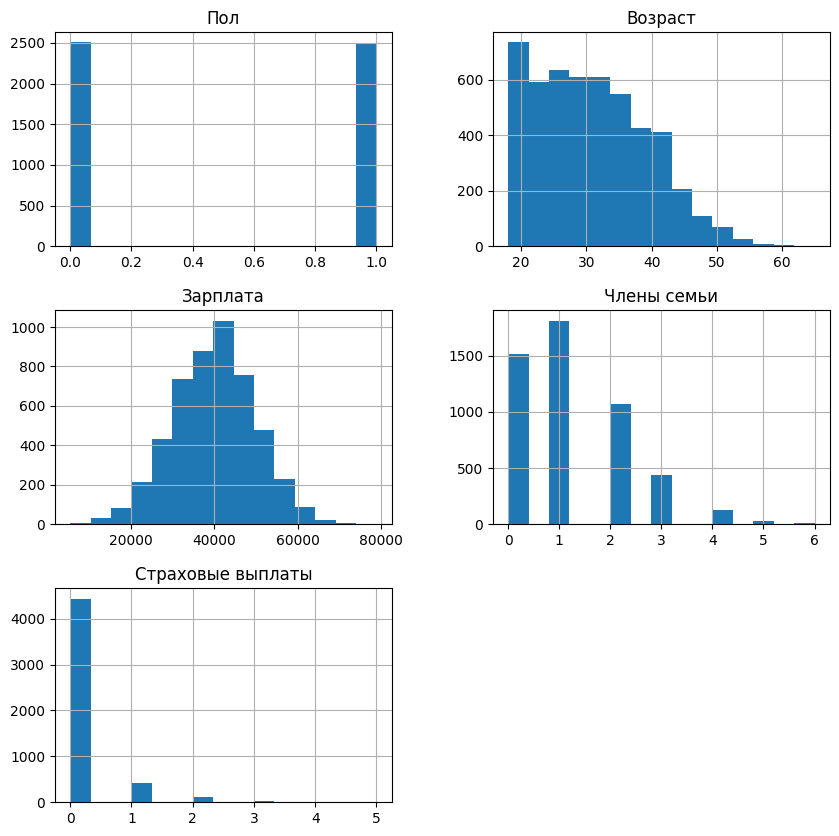

In [3]:
# Распределения признаков:
df.hist(bins=15, figsize=(10, 10));

<a id = 'c1'></a>
**Наблюдения:**

- Доминирующая доля объектов приходится на кол-во страховых выплат, равное 0 (почти 90%). Число объектов с тремя и более страховыми выплатами мизерно.
- Распределение клиентов по полам равномено.
- Среди клиентов преобладают молодые люди (до 35 лет).
- Распределение по зарплате близко к нормальному.
- Большинство клиентов либо одиночки (ок.30%), либо имеют одного члена семьи (ок. 35%).
- Явных всплесков в распределениях признаков нет.

**Вывод**

Данные не требуют подготовки и подходят для обучения моделей.

## Умножение признаков на обратимую матрицу

Для шифровки персональных данных клиентов предлагается домножить матрицу из признаков (которые и составляют персональные данные) на случайным образом сгенерированную обратимую матрицу и строить модель на основании преобразованных данных. В этом случае значение каждого из признаков трансформируется в некторое средневзвешенное значение (по правилам умножения матриц), которое само по себе не позволит идентифицировать клиента и его персональную информацию. При этом качество модели не пострадает. Тем не менее, такое преобразование затруднит интерпретацию коэффициентов в модели линейной регрессии.

### Теоретическое обоснование

Докажем, что **умножение матрицы признаков на обратимую матрицу не изменяет качество модели**. 

Обозначения:

- $X$ (размером $(n\times k)$) — матрица признаков (нулевой столбец состоит из единиц);

- $y$ (размером $n$) — вектор целевого признака;

- $P$ (размером $(k\times k)$) — обратимая матрица, на которую умножаются признаки;

- $w$ (размером $k$) — вектор весов линейной регрессии (нулевой элемент равен сдвигу).

Тогда линейная регрессия описывается как:
$$
y = Xw
$$

При этом вектор весов выбран таким образом, чтобы минимизировать среднеквадратичную ошибку, т.е.:
$$
w = \arg\min_w MSE(Xw, y)
$$

Решением задачи минимизации является вектор, записанный в виде:
$$
w = (X^T X)^{-1} X^T y \quad(1)
$$

**Доказательство**

Запишем новое выражение для линейной регрессии в виде:
$$
y = (XP)w' ,
$$

где $w'$ - новый вектор весов линейной регрессии. Тогда, решая задачу минимизации для нового вида линейной регрессиии, вектор $w'$ можно представить в виде:
$$
w' = ((XP)^T XP)^{-1} (XP)^T y \quad(2)
$$

Упростим выражение (2), применяя следующие свойства матриц:

- транспонирование произведения матриц равно произведению транспонированных матриц, взятых в обратном порядке
$$
(AB)^T = B^TA^T
$$

- матрица, обратная произведению матриц, равна произведению матриц, обратных матрицам-сомножителям, взятому в обратном порядке
$$
(AB)^{-1} = B^{-1}A^{-1}
$$

- транспонирование обратной матрицы равносильно вычислению обратной к транспонированной матрице
$$
(A^{-1})^T = (A^T)^{-1}
$$

- ассоциативность умножения матриц
$$
(AB)С = A(BC)
$$

<a id = 'c2'></a>
Тогда:

$$
w' = [(XP)^T XP]^{-1} (XP)^T y \Leftrightarrow \\
w' = (XP)^{-1}[(XP)^T]^{-1}(XP)^T y \Leftrightarrow \\
w' = P^{-1}X^{-1}[(XP)^T]^{-1}(XP)^T y \Leftrightarrow \\
w' = P^{-1}X^{-1}(P^TX^T)^{-1}(XP)^T y \Leftrightarrow \\
w' = P^{-1}X^{-1}(X^T)^{-1}(P^T)^{-1}(XP)^T y \Leftrightarrow \\
w' = P^{-1}X^{-1}(X^T)^{-1}(P^T)^{-1}P^TX^T y \Leftrightarrow \\
w' = P^{-1}X^{-1}(X^T)^{-1}EX^T y \quad\text{(где Е - единичная матрица)}\Leftrightarrow\\
w' = P^{-1}(X^TX)^{-1}X^T y \Leftrightarrow \\
w' = P^{-1}w \quad\text{(подставили выражение (1))} \quad(3)
$$

Помним, что выражения (2) и, как следствие, (3) были получены исходя из задачи минимизации MSE для двух видов моделей, однако это не говорит о равенстве или неравенстве значений MSE между собой.

Найдем выражения для MSE, а также для метрик $R^2$ и $MAE$ для двух видов регрессии: 

- $MSE$ (в знаменателе стоит $n+1$, т.к. нумерация строк матрицы начинается с 0 и заканчивается n):
$$
MSE = \frac{1} {n+1} \sum_{i=0}^{n} (y_i - \hat{y}_i)^2 \quad\text{(общая формула)}\\
MSE_{до}  = \frac{1} {n+1} \sum_{i=0}^{n} (y_i - (Xw)_i)^2 \\
MSE_{после} = \frac{1} {n+1} \sum_{i=0}^{n} (y_i - (XPw')_i)^2 = \frac{1} {n+1} \sum_{i=0}^{n} (y_i - (XPP^{-1}w)_i)^2 = MSE_{до}
$$

- $R^2$:
$$
R^2 = \frac{\sum_{i=0}^{n}(y_i - \hat{y}_i)^2} {\sum_{i=0}^{n} (y_i - \overline{y}_i)^2} = \frac{(n+1)\times MSE} {\sum_{i=0}^{n} (y_i - \overline{y}_i)^2}
$$

Т.к. домножение признаков на обратную матрицу не меняет вектор целевого признака и размерность матрицы признаков, а равнство MSE до и после преобразования доказана выше, метрика $R^2$ также не изменяется от домножения признаков на обратимую матрицу.

- $MAE$:
$$ MAE = \frac{1} {n+1} \sum_{i=0}^{n} |y_i - \hat{y}_i| \quad\text{(общая формула)}\\
MAE_{до} = \frac{1} {n+1} \sum_{i=0}^{n} |y_i - (Xw)_i| \\
MAE_{после} = \frac{1} {n+1} \sum_{i=0}^{n} |y_i - (XPw')_i| = \frac{1} {n+1} \sum_{i=0}^{n} |y_i - (XPP^{-1}w)_i| = MAE_{до}
$$

Таким образом, умножение матрицы признаков на обратимую матрицу не меняет качество модели линейной регрессии.

### Практическая проверка

Для защиты персональных данных через умножение на обратимую матрицу необходимо предпринять следующие действия:

1. Сгенерировать случайную матрицу размера $(k \times k)$, где $k$ - число признаков в модели, включая константу;
2. Проверить матрицу на обратимость путем нахождения обратной матрицы: если обратная матрица существует, значит, исходная матрица подходит для шифровки данных, а обратная ей - для дешифровки в случае необходимости. Если обратная к сгенерированной матрице не существует, повторить п.1.
3. Преобразовать исходные данные путем умножения на матрицу, сгенерированную в п.1.
4. Работать с моделью, обученной на преобразованных данных.

In [4]:
# Подготовим матрицу целевых признаков и вектор целевого признака:
features = df.drop('Страховые выплаты', axis=1)
col_names = list(features.columns)
features = np.concatenate((np.ones((features.shape[0],1), dtype=int), features), axis=1) # добавляем 1 для расчета константы
target = df['Страховые выплаты'].values
col_names = ['Единицы'] + col_names
print('Таблица признаков (пример):')
display(pd.DataFrame(features, columns = col_names).head(10)) # вывод в удобном виде

Таблица признаков (пример):


,Единицы,Пол,Возраст,Зарплата,Члены семьи
0,1.0,1.0,41.0,49600.0,1.0
1,1.0,0.0,46.0,38000.0,1.0
2,1.0,0.0,29.0,21000.0,0.0
3,1.0,0.0,21.0,41700.0,2.0
4,1.0,1.0,28.0,26100.0,0.0
5,1.0,1.0,43.0,41000.0,2.0
6,1.0,1.0,39.0,39700.0,2.0
7,1.0,1.0,25.0,38600.0,4.0
8,1.0,1.0,36.0,49700.0,1.0
9,1.0,1.0,32.0,51700.0,1.0


К исходным признакам была добавлена колонка из единиц, необходимая для расчета константы в уравнении линейной регрессии.

Обучим модель и найдем метрики качества на обучающей выборке:

In [5]:
# Функция для расчета метрик линейной регрессии:
def metrics_calc(x, y):
    model = LinearRegression()
    model.fit(x, y)
    r2 = r2_score(y, model.predict(x))
    mae = mean_absolute_error(y, model.predict(x))
    return r2, mae

# Найдем метрики для модели по исходным данным:
r2_initial, mae_initial = metrics_calc(features, target)
print('Значение R2 для линейной регрессии - {0: .4f}, MAE - {1: .4f}.'.
     format(r2_initial, mae_initial))

Значение R2 для линейной регрессии -  0.4249, MAE -  0.2531.


Теперь сгенерируем обратимую матрицу и рассмотрим метрики модели, обученной на преобразованнывх данных:

In [6]:
# Сгенерируем обратимую матрицу:
i = 0
while i==0:
    try:
        matrix = np.random.randint(1, 100, size=(features.shape[1], features.shape[1]))
        inv_matrix = np.linalg.inv(matrix)        # если обратная матрица генерируется, значит, изначальная матрица обратима
        i = 1                                     # завершаем попытки создать обратимую матрицу
    except:
        i = 0     # если возникла ошибка при расчете обратной матрицы, нужна еще попытка сгенерировать обратимую матрицу

print('Пример обратимой матрицы:')
print(matrix)

Пример обратимой матрицы:
[[96 42  4 27 94]
 [39 87 65 70 66]
 [86 50 40 96 53]
 [87 90 73 22 44]
 [34 79 59 67 39]]


Теперь рассмотрим признаки, преобразованные с помощью умножения на случайную обратимую матрицу:

Таблица преобразованных признаков (пример):


,Единицы,Пол,Возраст,Зарплата,Члены семьи
0,4318895.0,4466258.0,3622568.0,1095300.0,2184772.0
1,3310086.0,3422421.0,2775903.0,840510.0,1674571.0
2,1829590.0,1891492.0,1534164.0,464811.0,925631.0
3,3629870.0,3754250.0,3045062.0,919577.0,1836085.0
4,2273243.0,2350529.0,1906489.0,576985.0,1150044.0
5,3570901.0,3692437.0,2994907.0,906359.0,1806517.0
6,3457457.0,3575237.0,2899847.0,877375.0,1749105.0
7,3360621.0,3475695.0,2819105.0,851965.0,1700041.0
8,4327165.0,4475008.0,3629668.0,1097020.0,2188907.0
9,4500821.0,4654808.0,3775508.0,1140636.0,2276695.0


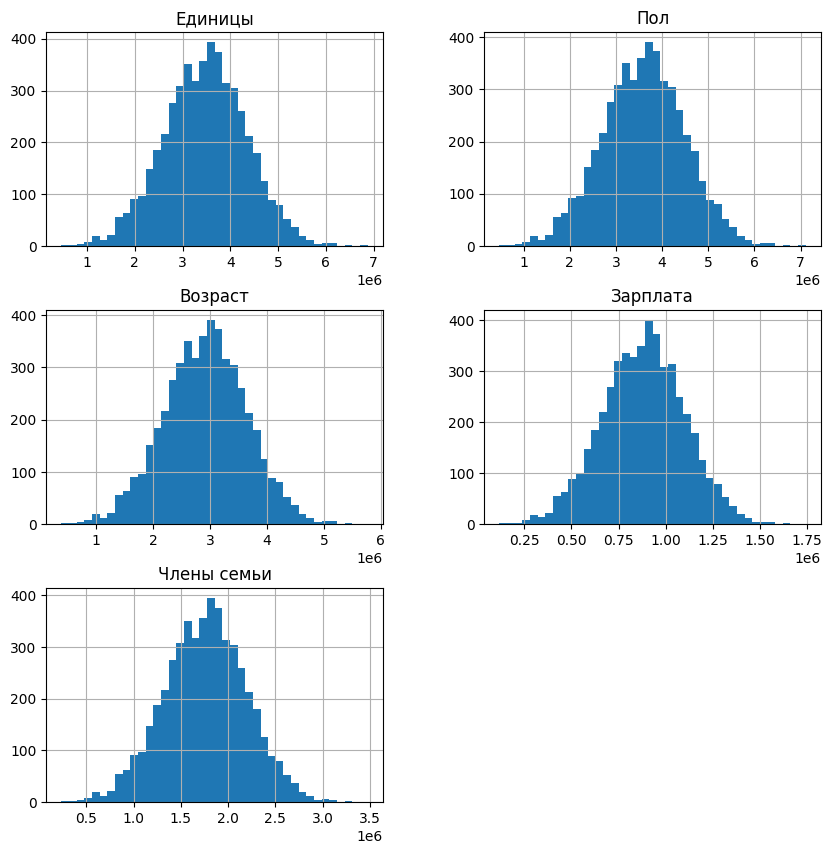

In [7]:
# Преобразуем матрицу признаков:
features_modified = features.dot(matrix) # домножили признаки на обратимую матрицу
print('Таблица преобразованных признаков (пример):')
display(pd.DataFrame(features_modified, columns = col_names).head(10)) # вывод в удобном виде
# Распределения преобразованных признаков:
pd.DataFrame(features_modified, columns = col_names).hist(bins=40, figsize=(10, 10));

Видим, что распределения признаков существенно изменились по сравнению с [исходными данными](#c1). Вектор единиц в результате преобразования также стал подчиняться распределению, приближенному к нормальному. Таким образом, задача шифрования персональных данных выполнена.

In [8]:
# Найдем метрики модели по преобразованным данным:
r2_modified, mae_modified = metrics_calc(features_modified, target)

print('Значение R2 для после преобразования признаков - {0: .4f}, MAE - {1: .4f}.'.
     format(r2_modified, mae_modified))
print('Отличия в показателе R2 - {0:.3f}, MAE - {1:.3f}.'.
     format(r2_initial - r2_modified, mae_initial - mae_modified))

Значение R2 для после преобразования признаков -  0.4249, MAE -  0.2531.
Отличия в показателе R2 - -0.000, MAE - -0.000.


Качесто модели осталось неизменным. Таким образом, практический пример подтверждает теоретичесткие выкладки.

## Масштабирование признаков

Для скрытия персональных данных клиентов можно также масштабировать данные (напр., методом стандартизации). Стандартизация признаков позволит перейти от персональной информации о клиенте в абсолютных значениях к относительным (выраженным в стандартных отклонениях). Данный метод плохо подходит для бинарных признаков (напр., пол), однако эту проблему можно решить путем скрытия названий колонок. Последовательность -1 и 1 может означать любой признак. При этом качество модели линейной регрессии не изменится.

### Теоретическое обоснование

Представим уравнение линейной регрессии в виде $y = a + Xw$. Константа вынесена за матрицу признаков, чтобы не создавать неопределенность при стандартизации (стандартное отклонение константы - 0).  Раскрывая:
$$
\begin{pmatrix}
a_0 \\
a_1 \\
... \\
a_n
\end{pmatrix} + 
\begin{pmatrix}
x_{00}& x_{01}& ... & x_{0k} \\
x_{10}& x_{11}& ... & x_{1k} \\
...& ...&...&... \\
x_{n0}& x_{n1}& ... & x_{nk}
\end{pmatrix}
\begin{pmatrix}
w_0 \\
w_1 \\
... \\
w_k
\end{pmatrix} = 
\begin{pmatrix}
a_0 \\
a_1 \\
... \\
a_n
\end{pmatrix} + 
\begin{pmatrix}
x_{00}w_0 + x_{01}w_1 + ... + x_{0k}w_k \\
x_{10}w_0 + x_{11}w_1 + ... + x_{1k}w_k \\
... \\
x_{n0}w_0 + x_{n1}w_1 + ... + x_{nk}w_k
\end{pmatrix} = 
\begin{pmatrix}
a_0 \\
a_1 \\
... \\
a_n
\end{pmatrix} + 
\begin{pmatrix}
\sum_{i=0}^{k}x_{0i}w_i \\
\sum_{i=0}^{k}x_{1i}w_i \\
...\\
\sum_{i=0}^{k}x_{ni}w_i
\end{pmatrix}
$$

Тогда уравнение линейной регрессии для стандартизованных признаков можно записать в виде $y = a' + X_{st}w'$, или:

$$
\begin{pmatrix}
a'_0 \\
a'_1 \\
... \\
a'_n
\end{pmatrix} + 
\begin{pmatrix}
\frac{x_{00} - \overline{x_0}}{s_0}&\frac{x_{01} - \overline{x_1}}{s_1}& ... & \frac{x_{0k} - \overline{x_k}}{s_k} \\
\frac{x_{10} - \overline{x_0}}{s_0}&\frac{x_{11} - \overline{x_1}}{s_1}& ... & \frac{x_{1k} - \overline{x_k}}{s_k} \\
...& ...&...&... \\
\frac{x_{n0} - \overline{x_0}}{s_0}&\frac{x_{n1} - \overline{x_1}}{s_1}& ... & \frac{x_{nk} - \overline{x_k}}{s_k}
\end{pmatrix}
\begin{pmatrix}
w'_0 \\
w'_1 \\
... \\
w'_k
\end{pmatrix} =
\begin{pmatrix}
a'_0 \\
a'_1 \\
... \\
a'_n
\end{pmatrix} +\begin{pmatrix}
\sum_{i=0}^{k}x_{0i}\frac{w'_i}{s_i} - \sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i} \\
\sum_{i=0}^{k}x_{1i}\frac{w'_i}{s_i} - \sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i} \\
...\\
\sum_{i=0}^{k}x_{ni}\frac{w'_i}{s_i} - \sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i}
\end{pmatrix} = \\
\begin{pmatrix}
a'_0 \\
a'_1 \\
... \\
a'_n
\end{pmatrix} +
\begin{pmatrix}
\sum_{i=0}^{k}x_{0i}\frac{w'_i}{s_i} \\
\sum_{i=0}^{k}x_{1i}\frac{w'_i}{s_i} \\
...\\
\sum_{i=0}^{k}x_{ni}\frac{w'_i}{s_i}
\end{pmatrix} - 
\begin{pmatrix}
\sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i} \\
\sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i} \\
...\\
\sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i}
\end{pmatrix}
$$

<a id='c3'></a>
Заметим, что значения вектора $w$ можно представить через $w'$: $w_j = \frac{w_j}{s_j}$, а значения вектора $a$ как $a_j = a'_j - \sum_{i=0}^{k}\frac{\overline{x_{i}}w'_i}{s_i}$. Таким образом, одну форму записи коэффициентов можно выразить через другую, т.е. качество модели остается неизменным.

### Практическая проверка

Для защиты персональных данных через стандартизацию необходимо предпринять следующие действия:

1. Найти среднее значение $\overline{x_i}$ и стандартное отклонение $s_i$ для каждого признака;
2. Преобразовать исходные данные по формуле 

$$ x_{j, i}^{st} = \frac{x_{j,i} - \overline{x_i}}{s_i}$$

3. Работать с моделью, обученной на преобразованных данных.

П.1 и 2 реализованы в инструменте из *StandardScaler* из библиотеки *sklearn*:

Таблица преобразованных признаков (пример):


,Единицы,Пол,Возраст,Зарплата,Члены семьи
0,0.0,1.002002,1.190432,0.978235,-0.177957
1,0.0,-0.998002,1.782851,-0.193589,-0.177957
2,0.0,-0.998002,-0.231375,-1.910918,-1.094314
3,0.0,-0.998002,-1.179247,0.180182,0.738401
4,0.0,1.002002,-0.349859,-1.395720,-1.094314
5,0.0,1.002002,1.427400,0.109469,0.738401
6,0.0,1.002002,0.953464,-0.021857,0.738401
7,0.0,1.002002,-0.705311,-0.132978,2.571115
8,0.0,1.002002,0.598012,0.988337,-0.177957
9,0.0,1.002002,0.124076,1.190376,-0.177957


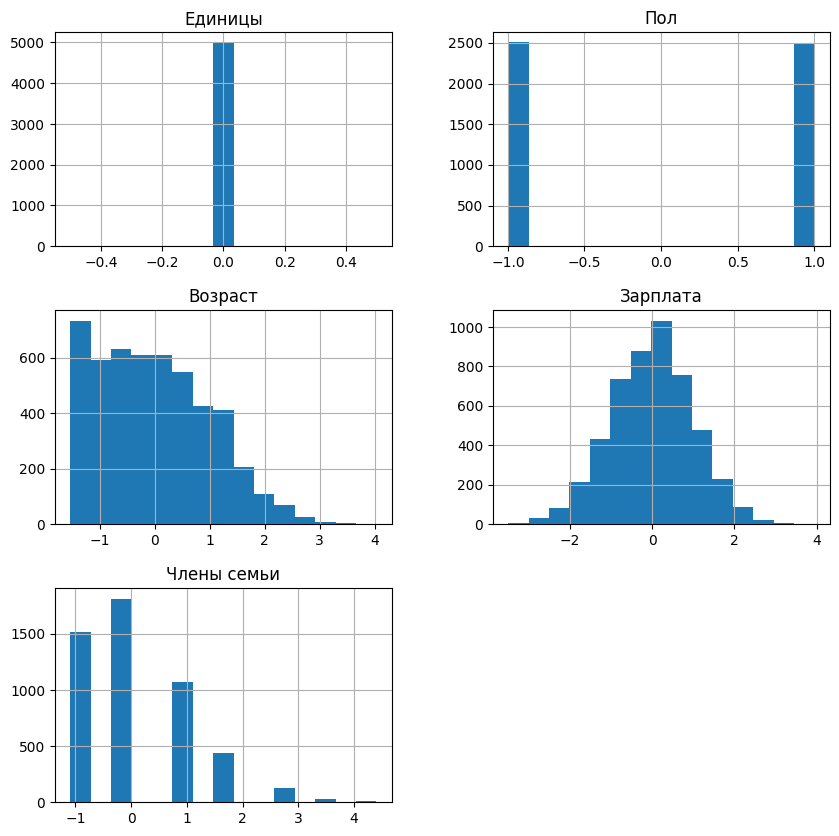

In [9]:
# Преобразуем матрицу признаков:
scaler = StandardScaler()
features_standard = scaler.fit_transform(features)
print('Таблица преобразованных признаков (пример):')
display(pd.DataFrame(features_standard, columns=col_names).head(10)) # вывод в удобном виде
# Распределения преобразованных признаков:
pd.DataFrame(features_standard, columns=col_names).hist(bins=15, figsize=(10, 10));

Форма распределений не изменилась по сравнению с [исходными данными](#c1), однако изменился масштаб данных, что затрудняет идентификацию персональных данных. Рассмотрим метрики модели:

In [10]:
# Найдем метрики качества линейной регрессии на стандартизованных данных:
r2_standard, mae_standard = metrics_calc(features_standard, target)

print('Значение R2 для после преобразования признаков - {0: .4f}, MAE - {1: .4f}.'.
     format(r2_standard, mae_standard))
print('Отличия в показателе R2 - {0:.3f}, MAE - {1:.3f}.'.
     format(r2_initial - r2_standard, mae_initial - mae_standard))

Значение R2 для после преобразования признаков -  0.4249, MAE -  0.2531.
Отличия в показателе R2 - -0.000, MAE - -0.000.


Проверка на реальных данных подтверждает постоянство метрик качества до и после стандартизации признаков.

## Общий вывод

Цель проекта состояла в предложении метода анонимизации персональных данных клиентов, который не влиял бы на качество используемой модели линейной регрессии.

Для подтверждения теоретических выкладок была предоставлена выборка размером 5 тыс. объектов. Пропуски в данных, а также явные аномалии в распределениях признаков отсутствовали. Значение $R^2$ для модели линейной регрессии на исходной (без преобразований) обучающей выборке составила ок. 0.425.

В качестве метода шифрования персональных данных был предложен метод умножения матрицы признаков на обратимую матрицу (ключ шифрования). При таком преобразовании веса линейной регрессии на преобразованных данных можно выразить через веса на исходных данных и ключ шифрования ([см. тут](#c2)) и качество модели остается неизменным, что подтверждено на данных.

Также была предложена стандартизация данных как метод защиты персональных данных. При таком преобразовании коэффициенты линейной регрессии на преобразованных данных также можно выразить через веса на исходных данных и значения среднего и стандартного отклонения признаков ([см. тут](#c3)). Т.е. качество модели также не изменяется, что подтверждается экспериментом на реальных данных.

Умножение на обратимую матрицу приводит к изменению как формы распределений, так и масштабов признаков, в то время как стандартизация изменяет только масштаб данных, не затрагивая форму распределений. Однако трактовка коэффициентов регрессии легче при стандартизации признаков. 

То есть, в случае, если цель анонимизации персональных данных преобладает над задачей интерпретации модели, более надежным методом защиты персональных данных является умножение признаков на обратимую матрицу.